In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import shap 
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.stats import chi2_contingency
import seaborn as sns
import folium
import plotly


In [11]:
# read in clean data
df = pd.read_csv("../../data/clean_data.csv")

In [12]:
# simple eda
df.head()

,Decision,State,GPA,WorkExp,TestScore,WritingScore,Gender,VolunteerLevel
0,Waitlist,Alabama,3.41,1.2,868,85,0,0
1,Admit,California,3.90,6.7,962,100,1,0
2,Admit,California,3.88,1.5,967,95,1,5
3,Admit,California,3.70,1.2,969,94,1,2
4,Admit,California,3.70,1.4,966,94,1,0


In [5]:
df.dtypes

Decision           object
State              object
GPA               float64
WorkExp           float64
TestScore         float64
WritingScore        int64
Gender            float64
VolunteerLevel      int64
dtype: object

In [109]:
df.describe()

,Decision,State,GPA,WorkExp,TestScore,WritingScore,Gender,VolunteerLevel
count,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000
mean,0.925000,3.175000,3.496500,2.147500,870.087500,81.612500,0.562500,2.462500
std,0.807794,2.109502,0.307534,1.774002,82.203698,15.912334,0.499208,1.698426
min,0.000000,0.000000,2.340000,0.000000,751.000000,1.000000,0.000000,0.000000
25%,0.000000,2.000000,3.397500,1.200000,769.000000,76.750000,0.000000,1.000000
50%,1.000000,3.000000,3.540000,1.550000,868.000000,83.500000,1.000000,2.000000
75%,2.000000,3.000000,3.700000,2.700000,965.250000,91.500000,1.000000,4.000000
max,2.000000,9.000000,3.930000,9.200000,969.000000,100.000000,1.000000,5.000000


Waitlist    28.75
Decline     35.00
Admit       36.25
Name: Decision, dtype: float64


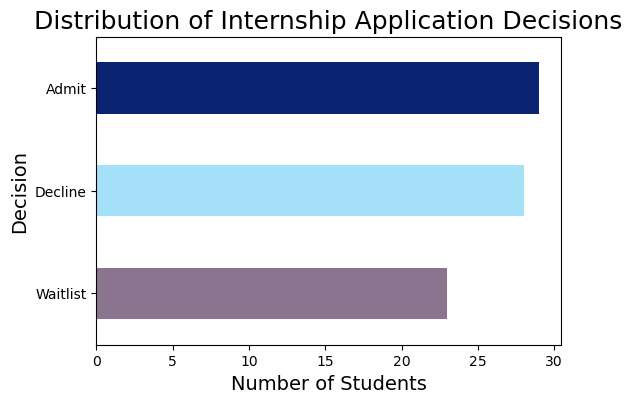

In [15]:
decision_counts = df['Decision'].value_counts()
decision_counts_sorted = decision_counts.sort_values(ascending=True)
decision_percentages = decision_counts / decision_counts.sum() * 100
decision_percentages_sorted = decision_percentages.sort_values(ascending=True)
print(decision_percentages_sorted)
colors = ['#8B748F', '#A6E1FA', '#0A2472']  

plt.figure(figsize=(6, 4))
decision_counts_sorted.plot(kind='barh', color=colors)
plt.title('Distribution of Internship Application Decisions', fontsize=18)
plt.ylabel('Decision',  fontsize=14)
plt.xlabel('Number of Students', fontsize=14)

plt.show()


# Gender

In [31]:
df.groupby(['Gender']).count()

,Decision,State,GPA,WorkExp,TestScore,WritingScore,VolunteerLevel
Gender,,,,,,,
0,35,35,35,35,35,35,35
1,45,45,45,45,45,45,45


In [17]:
# contingency table of observed frequencies
contingency_table_gen = pd.crosstab(df['Decision'], df['Gender'])

print("Contingency Table:")
print(contingency_table_gen)

chi2, p, dof, expected = chi2_contingency(contingency_table_gen)

print("\nChi-square Statistic:", chi2)
print("P-value:", p)

if p < 0.05:
    print("There is a significant association between gender and admission decisions, indicating potential bias.")
else:
    print("There is no significant association between gender and admission decisions, indicating no evidence of bias based on this test.")

Contingency Table:
Gender     0   1
Decision        
Admit     13  16
Decline   12  16
Waitlist  10  13

Chi-square Statistic: 0.023444060282783778
P-value: 0.9883464051925749
There is no significant association between gender and admission decisions, indicating no evidence of bias based on this test.


Gender            0          1
Decision                      
Admit     44.827586  55.172414
Decline   42.857143  57.142857
Waitlist  43.478261  56.521739


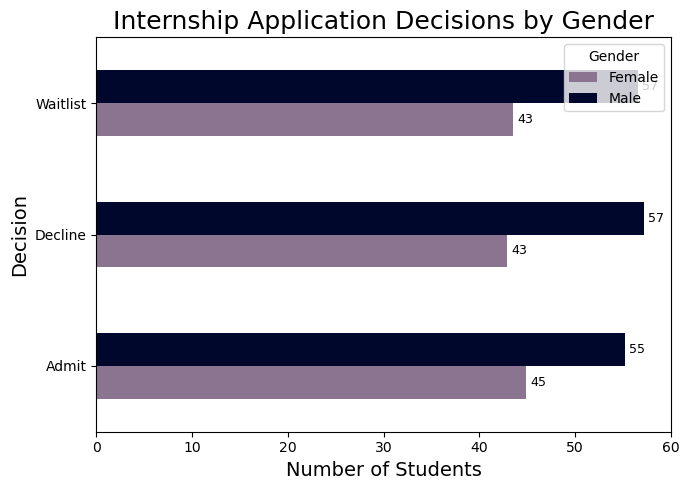

In [30]:
 # plotting gender distribution among Admission decisions
colors = ['#8B748F', '#00072D', '#0A2472']  
contingency_table_percent = contingency_table_gen.div(contingency_table_gen.sum(axis=1), axis=0) * 100
print(contingency_table_percent)
ax = contingency_table_percent.plot(kind='barh', stacked=False, color=colors, figsize=(7,5))

plt.title('Internship Application Decisions by Gender', fontsize=18)
plt.xlabel('Number of Students', fontsize=14)
plt.ylabel('Decision', fontsize=14)
plt.xticks(rotation=0)
plt.legend(title='Gender', labels=['Female', 'Male'])

# Add bar labels
for container in ax.containers:
    ax.bar_label(container, label_type='edge', padding=3, fontsize=9, fmt='%.0f')

plt.tight_layout()
plt.show()

# State

In [21]:
# contingency table of observed frequencies
contingency_table = pd.crosstab(df['Decision'], df['State'])

print("Contingency Table:")
print(contingency_table)

chi2, p, dof, expected = chi2_contingency(contingency_table)

print("\nChi-square Statistic:", chi2)
print("P-value:", p)

if p < 0.05:
    print("There is a significant association between state and admission decisions, indicating potential bias.")
else:
    print("There is no significant association between state and admission decisions, indicating no evidence of bias based on this test.")


Contingency Table:
State     Alabama  California  Colorado  Florida  Mississippi  New York  \
Decision                                                                  
Admit           0           9         8       11            0         0   
Decline         0           1         6       13            1         0   
Waitlist        1           2         4       11            0         1   

State     Oregon  Utah  Vermont  Virginia  
Decision                                   
Admit          0     1        0         0  
Decline        1     2        0         4  
Waitlist       0     3        1         0  

Chi-square Statistic: 29.14997943205268
P-value: 0.04657662409208843
There is a significant association between state and admission decisions, indicating potential bias.


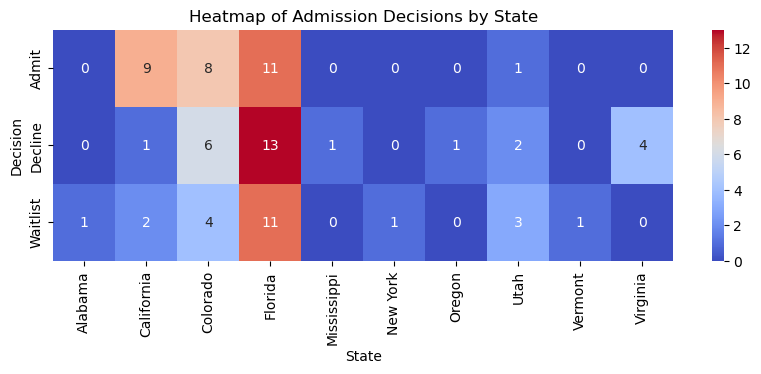

In [135]:
chi2, p, dof, expected = chi2_contingency(contingency_table)

expected_df = pd.DataFrame(expected, index=contingency_table.index, columns=contingency_table.columns)

std_residuals = (contingency_table - expected_df) / expected_df**0.5

significant_cells = std_residuals.abs() > 2
significant_cells

# True under California for Admit suggests that California has a 
# significantly higher number of admissions than would be expected if the decision 
# were independent of the state. Similarly, True under Virginia for Decline suggests 
# that Virginia has a significantly higher number of rejections than expected.

plt.figure(figsize=(10, 3))
sns.heatmap(contingency_table, annot=True, cmap='coolwarm', fmt='g')
plt.title('Heatmap of Admission Decisions by State')
plt.xlabel('State')
plt.ylabel('Decision')
plt.show()

In [152]:
import pandas as pd

# Assuming 'df' is your DataFrame containing the full dataset
# Replace 'df' with the actual name of your DataFrame

# Filter the dataset for students from California or Virginia
california_virginia_students = df[df['State'].isin(['California'])]

# Group the data by Decision (Admit, Decline, Waitlist) and calculate the average scores
average_scores_by_decision = california_virginia_students.groupby('Decision').mean()

# Print the average scores for each decision
print("Average Scores for Students from California and Virginia:")
print(average_scores_by_decision)


Average Scores for Students from California and Virginia:
               GPA   WorkExp   TestScore  WritingScore    Gender  \
Decision                                                           
Admit     3.764444  3.111111  946.444444     94.444444  0.555556   
Decline   2.340000  0.800000  754.000000     76.000000  1.000000   
Waitlist  3.495000  2.450000  861.000000     82.000000  1.000000   

          VolunteerLevel  
Decision                  
Admit           2.555556  
Decline         1.000000  
Waitlist        4.000000  


/var/folders/79/jdv69xcs22z7cyxln5rsbzzh0000gn/T/ipykernel_14546/764148454.py:10: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



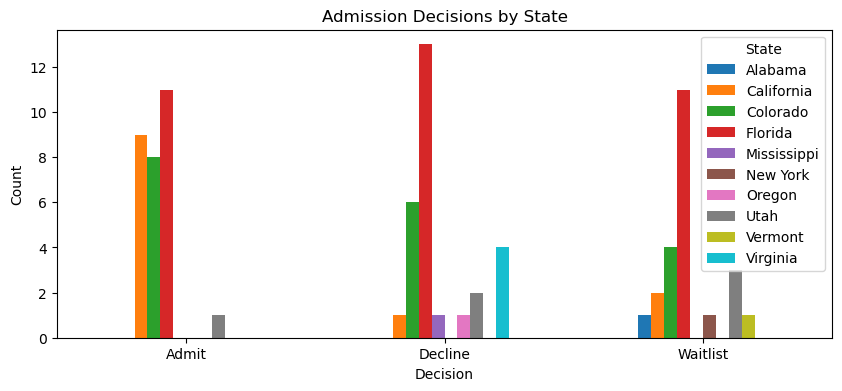

In [31]:
# plotting state distribution among Admission decisions
contingency_table.plot(kind='bar', stacked=False, figsize=(10, 4))
plt.title('Admission Decisions by State')
plt.xlabel('Decision')
plt.ylabel('Count')
plt.xticks(rotation=0)  
plt.show()

In [53]:
# Plotting % of state distribution on a map
admissions_by_state = df[['State','Decision']]

total_counts = admissions_by_state.groupby('State').size().reset_index(name='Total')

decision_counts = admissions_by_state.groupby(['State', 'Decision']).size().reset_index(name='Counts')

decision_counts = decision_counts.merge(total_counts, on='State')

decision_counts['Percentage'] = (decision_counts['Counts'] / decision_counts['Total']) * 100
decision_counts

,State,Decision,Counts,Total,Percentage
0,Alabama,Waitlist,1,1,100.000000
1,California,Admit,9,12,75.000000
2,California,Decline,1,12,8.333333
3,California,Waitlist,2,12,16.666667
4,Colorado,Admit,8,18,44.444444
5,Colorado,Decline,6,18,33.333333
6,Colorado,Waitlist,4,18,22.222222
7,Florida,Admit,11,35,31.428571
8,Florida,Decline,13,35,37.142857
9,Florida,Waitlist,11,35,31.428571


In [56]:
import plotly.express as px

# Filter for a specific decision type
admitted_data = decision_counts[decision_counts['Decision'] == 'Admit']

state_abbreviations = {
    'California': 'CA',
    'Florida': 'FL',
    'Colorado': 'CO',
    'Utah': 'UT',
    'Oregon': 'OR',
    'Virginia': 'VA',
    'Mississippi': 'MS',
    'New York': 'NY',
    'Alabama': 'AL',
    'Vermont': 'VT',

    # Add other states as necessary
}
decision_counts['State'] = decision_counts['State'].map(state_abbreviations)
 
fig = px.choropleth(
    admitted_data,
    locations='State',  # Assumes 'State' contains state names or abbreviations
    locationmode='USA-states',
    color='Percentage',  # Values that you want to color-code
    color_continuous_scale=px.colors.sequential.Plasma,
    scope='usa',
    labels={'Percentage': 'Percentage Admitted'}
)

fig.update_layout(
    title_text='Percentage of Admitted Decisions by State'
)

fig.show()


In [58]:
# trying to add a button to toggle between admit, decline and waitlist
import plotly.graph_objects as go

# Function to format the hover text with percentage
def format_hover_text(df):
    return df.apply(lambda row: f"{row['State']}: {row['Percentage']:.2f}%", axis=1)

# Create a base figure
fig = go.Figure()

# Function to add traces for each decision type
def add_trace_for_decision(fig, decision_data, decision_type):
    fig.add_trace(
        go.Choropleth(
            locations=decision_data['State'],
            z=decision_data['Percentage'].astype(float),  # Ensure percentage is float
            locationmode='USA-states',
            colorscale=px.colors.sequential.Plasma,
            autocolorscale=False,
            showscale=True,  # Show color scale
            zmin=0,  # Minimum of color scale
            zmax=100,  # Maximum of color scale
            hoverinfo='text',  # Show custom text in hover
            text=format_hover_text(decision_data),  # Custom hover text
            name=decision_type,  # Name used for button labels
            visible=(decision_type == 'Admit')  # Only 'Admit' is visible by default
        )
    )

# Add a trace for each decision type
for decision_type in ['Admit', 'Decline', 'Waitlist']:
    decision_data = decision_counts[decision_counts['Decision'] == decision_type]
    add_trace_for_decision(fig, decision_data, decision_type)

# Update layout with buttons
decision_buttons = [
    dict(label=decision_type,
         method='update',
         args=[{'visible': [decision == decision_type for decision in ['Admit', 'Decline', 'Waitlist']]},
               {'title': f'Percentage of {decision_type} Decisions by State'}])
    for decision_type in ['Admit', 'Decline', 'Waitlist']
]

fig.update_layout(
    updatemenus=[dict(active=0,
                      buttons=decision_buttons,
                      x=0.15,  # Button group position
                      xanchor='left',
                      y=1.15,
                      yanchor='top')],
    title_text='Percentage of Admitted Decisions by State',
    geo=dict(scope='usa', lakecolor='rgb(255, 255, 255)'),
)

fig.show()


In [42]:
 # using folium (not great output)
decision_counts = admissions_by_state.groupby(['State', 'Decision']).size().unstack(fill_value=0).reset_index()

# GeoJSON file path
geo_url = 'https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json'

# Initialize the base map
m = folium.Map(location=[37.0902, -95.7129], zoom_start=5)

# Function to add a choropleth layer
def add_choropleth_layer(map_obj, geojson_path, data_df, decision_type, fill_color):
    folium.Choropleth(
        geo_data=geojson_path,
        name=decision_type,
        data=data_df,
        columns=['State', decision_type],
        key_on='feature.properties.name',  # Adjust based on your GeoJSON structure
        fill_color=fill_color,
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name=f'{decision_type} Decisions by State'
    ).add_to(map_obj)

# Adding each decision type as a separate layer with ColorBrewer palettes
decision_types = ['Admit', 'Decline', 'Waitlist']
colors = ['YlGn', 'OrRd', 'PuBu']  # ColorBrewer palettes for each layer

for decision, color in zip(decision_types, colors):
    add_choropleth_layer(m, geo_url, decision_counts, decision, color)

# Add layer control to toggle layers
folium.LayerControl().add_to(m)

m.save('decision_distribution_by_state.html')


# XGBoost

In [13]:
# encode target variable with separate label encoders
state_encoder = LabelEncoder()
df['State'] = state_encoder.fit_transform(df['State'])
print(state_encoder.classes_)

decision_encoder = LabelEncoder()
df['Decision'] = decision_encoder.fit_transform(df['Decision'])
print(decision_encoder.classes_)
# ['Admit', 'Decline', 'Waitlist']

df.head()


['Alabama' 'California' 'Colorado' 'Florida' 'Mississippi' 'New York'
 'Oregon' 'Utah' 'Vermont' 'Virginia']
['Admit' 'Decline' 'Waitlist']


,Decision,State,GPA,WorkExp,TestScore,WritingScore,Gender,VolunteerLevel
0,2,0,3.41,1.2,868,85,0,0
1,0,1,3.90,6.7,962,100,1,0
2,0,1,3.88,1.5,967,95,1,5
3,0,1,3.70,1.2,969,94,1,2
4,0,1,3.70,1.4,966,94,1,0


In [45]:
df.shape

(80, 8)

In [50]:
# split up data 
X = df.drop('Decision', axis=1)
y = df['Decision']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [51]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(56, 7)
(56,)
(24, 7)
(24,)


In [52]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

# initialize classifier
xgb_clf = xgb.XGBClassifier(
    learning_rate=0.1,  
    n_estimators=100,  
    max_depth=4, 
    min_child_weight=1,  
    gamma=0.1, 
    reg_lambda=1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softprob',
    num_class=3,
    random_state=42
)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracy_scores = cross_val_score(xgb_clf, X, y, cv=skf, scoring='accuracy')
print(f"Cross-validated accuracy: {np.mean(accuracy_scores):.2f} ± {np.std(accuracy_scores):.2f}")

# # train
# model = xgb_clf.fit(X_train, y_train)

# # test
# y_pred = model.predict(X_test)
# y_prob = model.predict_proba(X_test)

model = xgb_clf.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


Cross-validated accuracy: 0.93 ± 0.07
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         9

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24

[[8 0 0]
 [0 7 0]
 [0 0 9]]


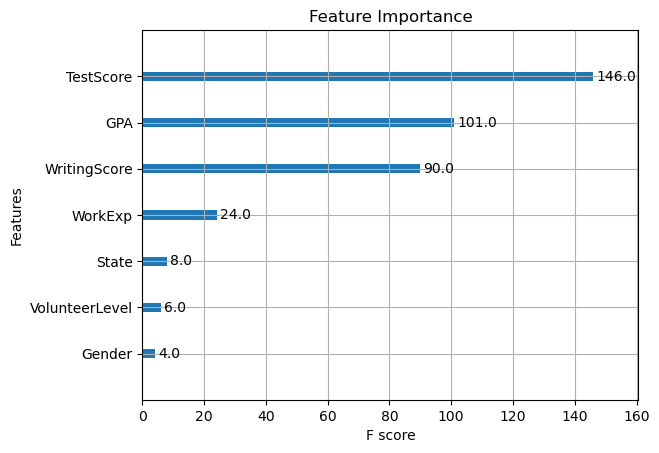

In [53]:
# visualize xgb feat importance
xgb.plot_importance(model)
plt.title('Feature Importance')
plt.show()

[0 1 2]


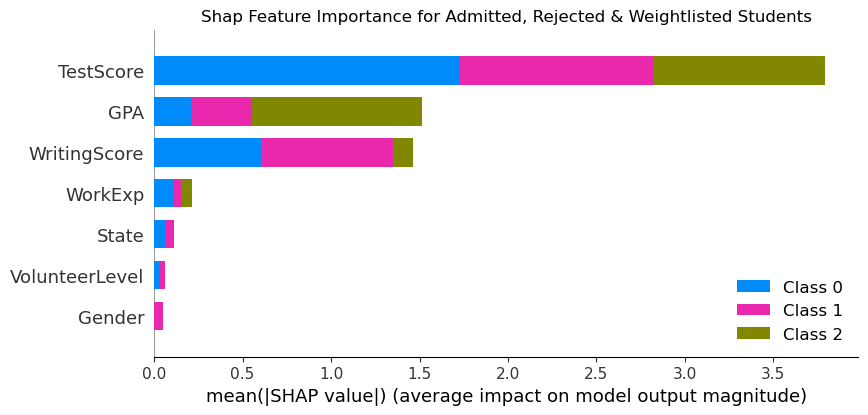

In [57]:
# Calculate SHAP values
import shap 
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

print(model.classes_)

fig = plt.figure()
shap.summary_plot(shap_values, X_test, plot_type="bar", show = False)
plt.gcf().set_size_inches(9,4)
plt.title("Shap Feature Importance for Admitted, Rejected & Weightlisted Students")
plt.show()

# ['Admit' 'Decline' 'Waitlist']
#    0         1         2

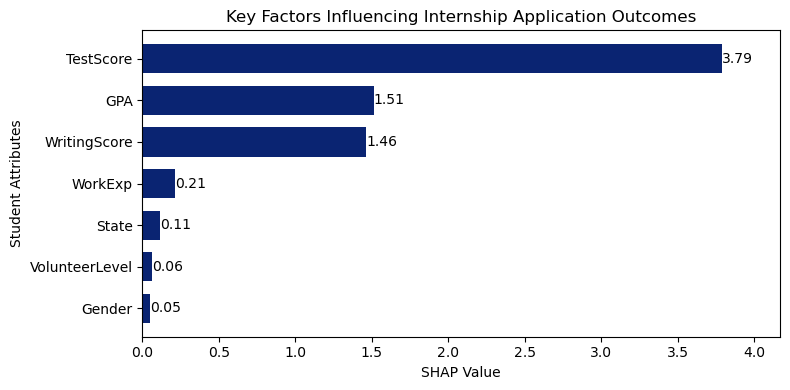

<Figure size 640x480 with 0 Axes>

In [134]:
summed_shap_values = np.sum([np.abs(sv) for sv in shap_values], axis=0).mean(axis=0)
shap_series = pd.Series(summed_shap_values, index=X_test.columns)
shap_series_sorted = shap_series.sort_values(ascending=True)

plt.figure(figsize=(8, 4))
shap_df_sorted = shap_series_sorted.to_frame(name="Mean Abs SHAP Value")
y_pos = np.arange(len(shap_df_sorted))

bars = plt.barh(y_pos, shap_df_sorted["Mean Abs SHAP Value"], color='#0A2472', height=0.7)  # Adjust 'height' for bar width
plt.yticks(y_pos, shap_df_sorted.index)

# add value labels to each bar
for bar in bars:
    plt.text(
        bar.get_width(),  # X position, slightly to the right of the bar end
        bar.get_y() + bar.get_height() / 2,  # Y position, at the center of the bar
        f'{bar.get_width():.2f}',  # The label, formatted to two decimal places
        va='center',  # Center alignment vertically
        ha='left'  # Left align the text (so it starts at the bar end)
    )

plt.xlim(0, max(shap_df_sorted["Mean Abs SHAP Value"]) * 1.1)  # Add 10% more space to the right

plt.title("Key Factors Influencing Internship Application Outcomes")
plt.xlabel("SHAP Value")
plt.ylabel("Student Attributes")

plt.tight_layout()
plt.show()
plt.savefig('../../website/images/overall_shap.png', dpi=300, bbox_inches='tight')


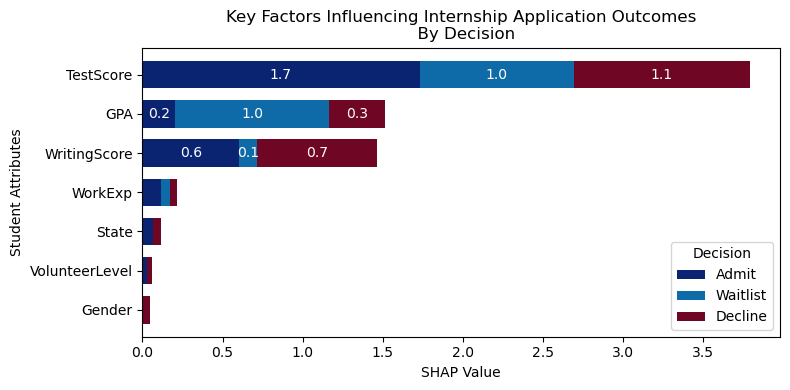

<Figure size 640x480 with 0 Axes>

In [135]:
mean_shap_values_per_class = [np.abs(shap_values[class_idx]).mean(0) for class_idx in range(len(model.classes_))]
shap_df = pd.DataFrame(mean_shap_values_per_class, index=['Admit', 'Decline', 'Waitlist'], columns=X_test.columns).T
shap_df = shap_df[['Admit', 'Waitlist', 'Decline']]

shap_df['Total'] = shap_df.sum(axis=1)

shap_df_sorted = shap_df.sort_values('Total', ascending=True).drop('Total', axis=1)

colors = ['#0A2472', '#0E6BA8', '#6F0624']  

fig, ax = plt.subplots(figsize=(8, 4))
bar_width = 0.7  # Custom bar width
y_pos = np.arange(len(shap_df_sorted))

# Iterate over each decision class to plot
for i, (decision, color) in enumerate(zip(shap_df_sorted.columns, colors)):
    starts = shap_df_sorted.iloc[:, :i].sum(axis=1) if i > 0 else np.zeros(len(shap_df_sorted))
    rects = ax.barh(y_pos, shap_df_sorted[decision], bar_width, left=starts, label=decision, color=color)
    
    # Process only the last three bars
    for rect in rects[-3:]:
        width = rect.get_width()
        label_x_pos = rect.get_x() + width / 2
        ax.text(label_x_pos, rect.get_y() + rect.get_height() / 2, f'{width:.1f}', ha='center', va='center', color='white')

ax.set_yticks(y_pos)
ax.set_yticklabels(shap_df_sorted.index)

ax.set_title("Key Factors Influencing Internship Application Outcomes\n  By Decision")
ax.set_xlabel("SHAP Value")
plt.ylabel("Student Attributes")
ax.legend(title="Decision")

plt.tight_layout()
plt.show()

plt.savefig('../../website/images/breakout_shap.png', dpi=300, bbox_inches='tight')


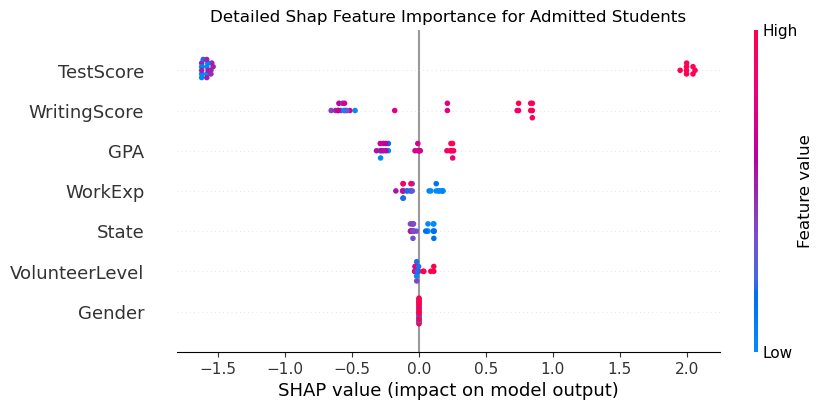

In [61]:
# ddetailed summary plots
class_index = 0

shap.summary_plot(shap_values[class_index], X_test, plot_type="dot", show=False)
plt.gcf().set_size_inches(9,4)
plt.title("Detailed Shap Feature Importance for Admitted Students")
plt.show()


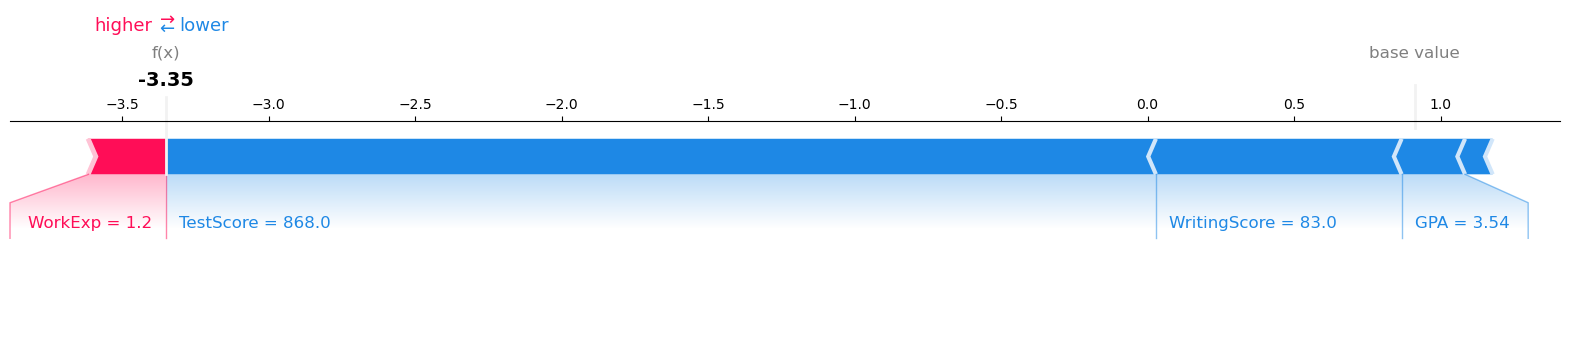

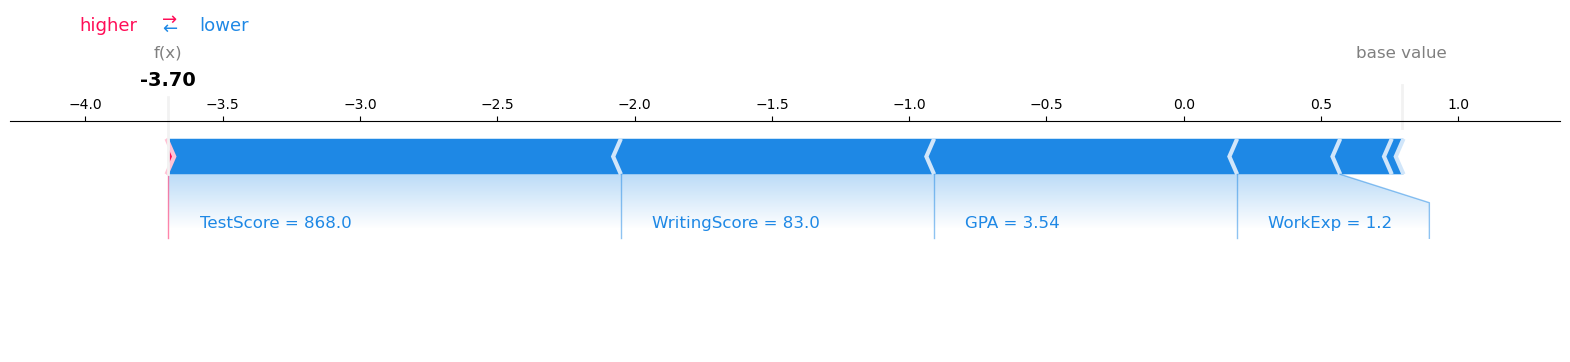

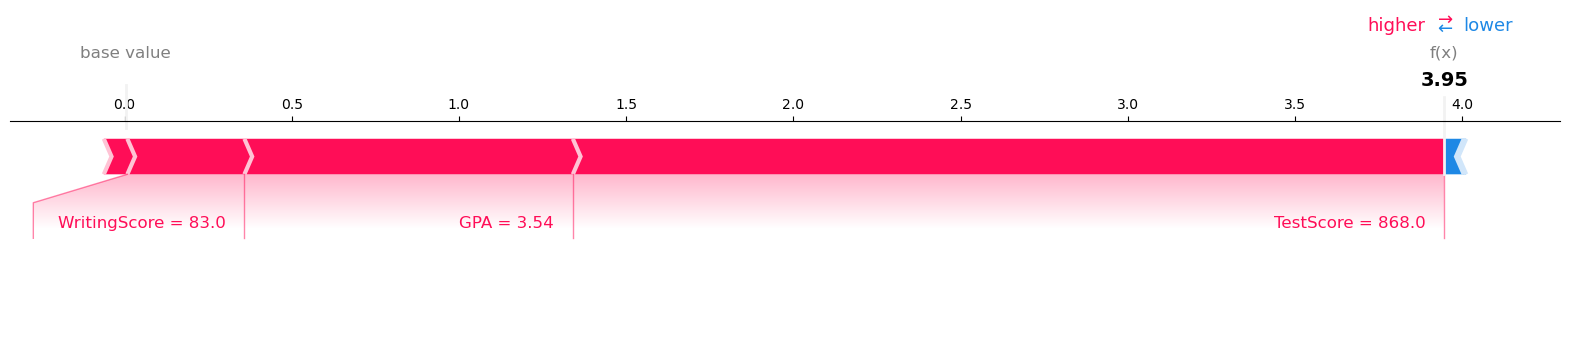

In [73]:
for class_idx in range(0,3):
    shap.force_plot(explainer.expected_value[class_idx], shap_values[class_idx][0,:], X_test.iloc[0,:], matplotlib=True)


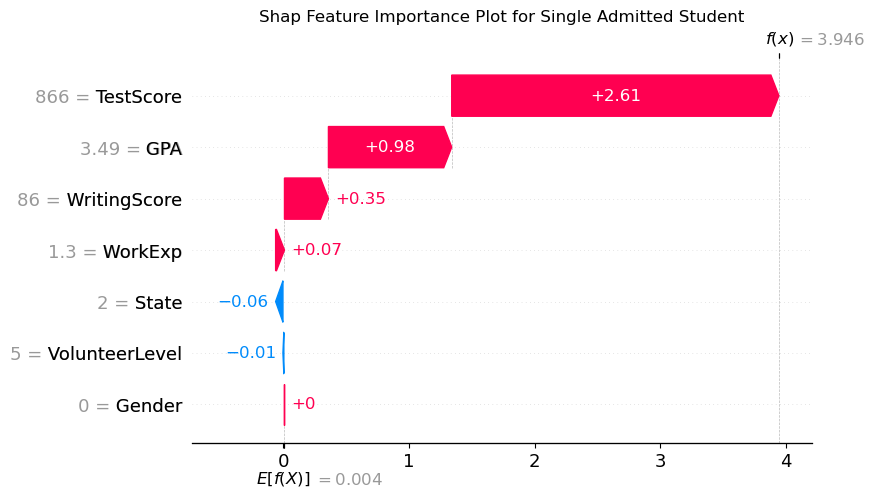

In [74]:
expl = shap.Explanation(values=shap_values[2][0],
                        base_values=explainer.expected_value[2],
                        data=X_test.iloc[5,:],
                        feature_names=X_test.columns.tolist())

shap.plots.waterfall(expl, show=False)
plt.title("Shap Feature Importance Plot for Single Admitted Student")
plt.show()

#https://towardsdatascience.com/explainable-ai-xai-with-shap-multi-class-classification-problem-64dd30f97cea